In [2]:
!pip install pennylane
!pip install tensorflow_quantum
!pip uninstall tensorflow-quantum -y

  Using cached tensorflow_quantum-0.7.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.7 kB)
Using cached tensorflow_quantum-0.7.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.8 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-datastore 2.19.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.28.3 which is incompatible.
google-cloud-firestore 2.16.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.28.3

In [6]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

num_cities = 5
num_layers = 2  # Number of QAOA layers

# Define a PennyLane device to simulate quantum computations
dev = qml.device("default.qubit", wires=num_cities)

In [7]:
np.random.seed(42) #here we dont want our output to have different solutions
#so placing a random value can outpout the same value for both pnp (pennylane numpy)
#and the np (classical numpy)
coordinates = np.random.rand(num_cities, 2)
#this allows us to designate our coordinate position to our specified city
#example: city1: (0,28, 0,82)
#the 2 indicates our 2D axis meaning we want our coordinate to be in x and y axis
#again our coordinates must be between 0 and 1

In [9]:
#so here we want to calculate our euclidian distance
def calculate_euclidian_distance(city_coordinates):
    #indication total number of cities
    n = len(city_coordinates)
    #we create an emtpy matrix with nxn matrix
    #and we append our coordiantes into this nxn empty matrix
    distance_matrix = np.zeros((n, n))
    #iteration through every row
    for i in range(n):
        #iterating through every column (where we exclude the initial column value)
        #because we want to avoid calculating the distance for itself
        #like instead of calculating from A to A we dont want that
        #so we want like 1 + 2 , 1 + 3 not 1 + 1 its redundant
        for j in range(i+1, n):
            #here we calculate the euclidian distance
            distance = np.linalg.norm(city_coordinates[i] - city_coordinates[j])
            #our overall matrix is symmetric meaning whatever our coordinates is when representing
            #in i, j should be the samew as when represnting in j i
            #to avoid any confusion in regards to our euclidian distance value
            distance_matrix[i, j] = distance_matrix[j, i] = distance

    ##finally return the euclidian distance value
    return distance_matrix
# Change 'city_coordinates' to 'coordinates' in the function call
distance_matrix = calculate_euclidian_distance(coordinates)
print("Distance_matrix:\n", distance_matrix)
#

Distance_matrix:
 [[0.         0.5017136  0.82421549 0.32755369 0.33198071]
 [0.5017136  0.         0.72642889 0.72506609 0.17058938]
 [0.82421549 0.72642889 0.         0.71690251 0.7091551 ]
 [0.32755369 0.72506609 0.71690251 0.         0.56557921]
 [0.33198071 0.17058938 0.7091551  0.56557921 0.        ]]


In [10]:
#main criteria:
#represent the total distance
#of a route between cities in a mathematical form that a quantum computer can understand and work with.
#the output distance will be converted to qubits
def cost_hamiltonian(gamma):
  ##gamma is a specific angle variable for our PAULI Z operator
    for i in range(num_cities):
        for j in range(i + 1, num_cities):
            distance = distance_matrix[i, j]
            qml.CNOT(wires=[i, j])
            qml.RZ(2 * gamma * distance, wires=j)
            qml.CNOT(wires=[i, j])

In [11]:
#explaning it in very simple terms for kids
#when we shoot the ball, the shooting part is the angle
#this indicates how much you are altering your "beta angle" foot
#to ensure it directs the ball into the correct direction
#which can go in many optimal direction but tweaking your foot
#can allow the ball to closely reach the goal
def mixer_hamiltonian(beta):
    for i in range(num_cities):
        qml.RX(2 * beta, wires=i)
#

In [12]:
@qml.qnode(dev)
def qaoa_circuit(gammas, betas):
    # Applying the QAOA layers one by one
    for gamma, beta in zip(gammas, betas):
      #these are for EACH QAIA layer
        cost_hamiltonian(gamma)   # Apply cost Hamiltonian for the current gamma
        mixer_hamiltonian(beta)   # Apply mixer Hamiltonian for the current beta
    return qml.expval(qml.PauliZ(0))  # Measurement (can be adjusted as needed)

In [13]:
def cost_function(params):
    num_layers = len(params) // 2
    gammas = params[:num_layers]
    betas = params[num_layers:]
    return qaoa_circuit(gammas, betas)

Iteration 0: Cost = -0.07767483914607642
Iteration 10: Cost = -0.302338486325302
Iteration 20: Cost = -0.5223350258871834
Iteration 30: Cost = -0.768288239598392
Iteration 40: Cost = -0.9190528566829456
Iteration 50: Cost = -0.9724840125081164
Iteration 60: Cost = -0.9880513595217155
Iteration 70: Cost = -0.9929229374760785
Iteration 80: Cost = -0.9949102613311697
Iteration 90: Cost = -0.9960112715674714


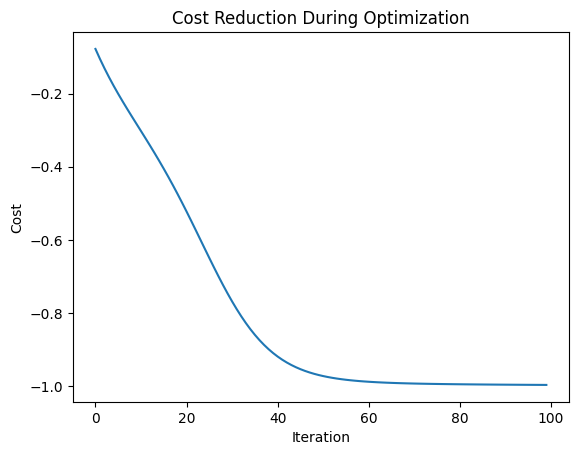

In [14]:
# Initialize random parameters
params = np.random.rand(2 * num_layers, requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.01)

# Optimization loop
num_iterations = 100
costs = []

for i in range(num_iterations):
    params, cost = opt.step_and_cost(cost_function, params)
    costs.append(cost)
    if i % 10 == 0:
        print(f"Iteration {i}: Cost = {cost}")

# Plot the cost reduction over iterations
plt.plot(costs)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Reduction During Optimization")
plt.show()


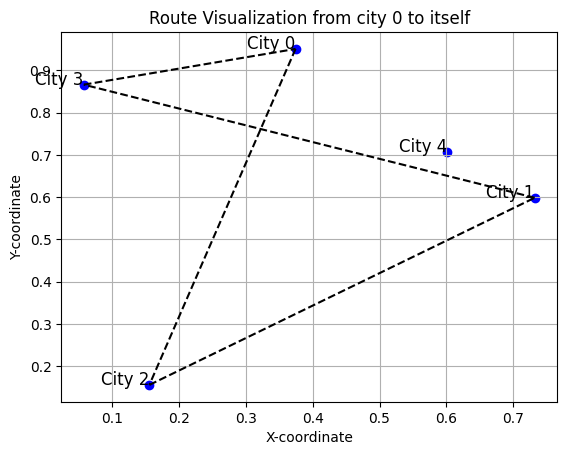

In [18]:
def plot_route(coords, route):
    plt.scatter(coords[:, 0], coords[:, 1], color="blue", marker="o")
    for i, (x, y) in enumerate(coords):
        plt.text(x, y, f"City {i}", fontsize=12, ha='right')

    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.title("Route Visualization from city 0 to itself")
    plt.grid(True)
    for i in range(len(route)):
        start = route[i]
        end = route[(i + 1) % len(route)]
        plt.plot([coords[start, 0], coords[end, 0]], [coords[start, 1], coords[end, 1]], 'k--')

optimal_route = [0, 2, 1, 3, 0]  #just an example but over time perioud of time I will
#make sure to have more real time optimization routes
plot_route(coordinates, optimal_route)
